#Coefficients

$M(q)\ddot{q}+ C(q,\dot{q})\dot{q} + g(q) = Bu$

In [0]:
import numpy as np
from math import cos, sin


# coefficients
g = 9.8
l = np.array([2,2])

def m():
  return np.array([1, 1])

def lc():
  return np.array([1, 1])

I = np.array([(m()[0]*(lc()[0]*lc()[0]*lc()[0] + (l[0]-lc()[0])*(l[0]-lc()[0])*(l[0]-lc()[0])))/(3*l[0]),
              (m()[1]*(lc()[1]*lc()[1]*lc()[1] + (l[1]-lc()[1])*(l[1]-lc()[1])*(l[1]-lc()[1])))/(3*l[1])])

# matrices
def M(q):
  m00 = m()[0]*lc()[0]**2 + m()[1]*(l[0]**2 + lc()[1]**2 + 2*l[0]*lc()[1]*cos(q[1])) + I[0] + I[1]
  m01 = m10 = m()[1]*(lc()[1]*lc()[1] + l[0]*lc()[1]*cos(q[1])) + I[1]
  m11 = m()[1]*lc()[1]*lc()[1] + I[1]
  return np.array([[m00, m01],
                   [m10, m11]])
  
def C(q, qdot):
  # print(q)
  h = -m()[1]*l[0]*lc()[1]*sin(q[1])
  return np.array([[h*qdot[1], h*(qdot[0]+qdot[1])],
                   [-h*qdot[0], 0]])
  
def G(q):
  return np.array([(m()[0]*lc()[0] + m()[1]*l[0])*g*cos(q[0]) + m()[1]*lc()[1]*g*cos(q[0]+q[1]),
                   m()[1]*lc()[1]*g*cos(q[0]+q[1])])


# input
B = np.array([[1,0],[0,1]])
u = np.array([[0,0]])


# state
q = np.array([0,0])
qdot = np.array([0,0])

#Simulating the system

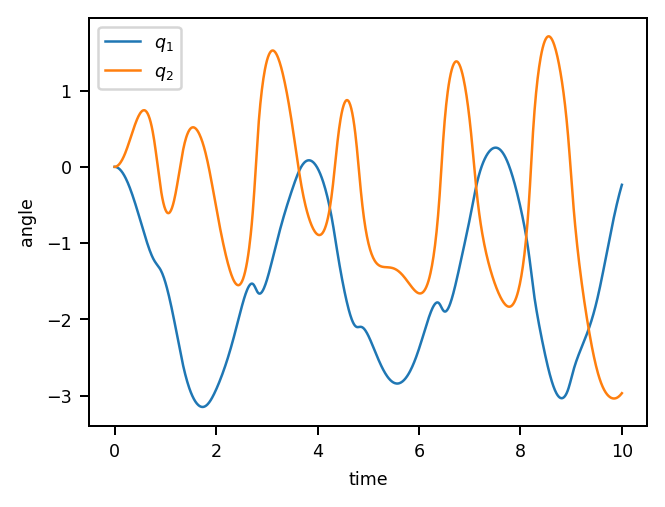

In [218]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def system(x,t,u):
  x = x.reshape(4,1)
  state = np.array([x[:2], x[2:]])

  M_inv = np.linalg.inv(M(state[0]))
  qdot_term = -M_inv.dot((C(state[0],state[1]).dot(state[1])) +G(state[0]).reshape(2,1)).flatten()
  f = np.array([state[1][0],state[1][1],
                qdot_term[0], qdot_term[1]]).reshape(4,1)
  
  M_inv_B = M_inv.dot(B).dot(u)
  gu = np.array([[0],[0], M_inv_B[0], M_inv_B[1]])
  # print((f+gu).flatten())
  return (f+gu).flatten()

def discrete(x, time):
  plot = [x]
  for i in range(len(time)-1):
    u = np.array([[0],[0]])
    result = odeint(system, x, [time[i], time[i+1]], args=(u,))
    plot.append(result[1])
    x = result[1]
  
  return np.array(plot)

t = np.linspace(0,10,1000)

q = np.array([0,0])
qdot = np.array([0,0])
x = np.array([q,qdot]).flatten()

solution = odeint(system, x, t, (np.array([[0],[0]]),))

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 180
plt.rcParams['lines.linewidth'] = 1


plt.plot(t, solution[:,0], label='$q_1$')
plt.plot(t, solution[:,1], label='$q_2$')
# plt.plot(t, solution[:,2], label='q3')
# plt.plot(t, solution[:,3], label='q4')
plt.xlabel("time")
plt.ylabel("angle")
plt.legend()
plt.show()
                   

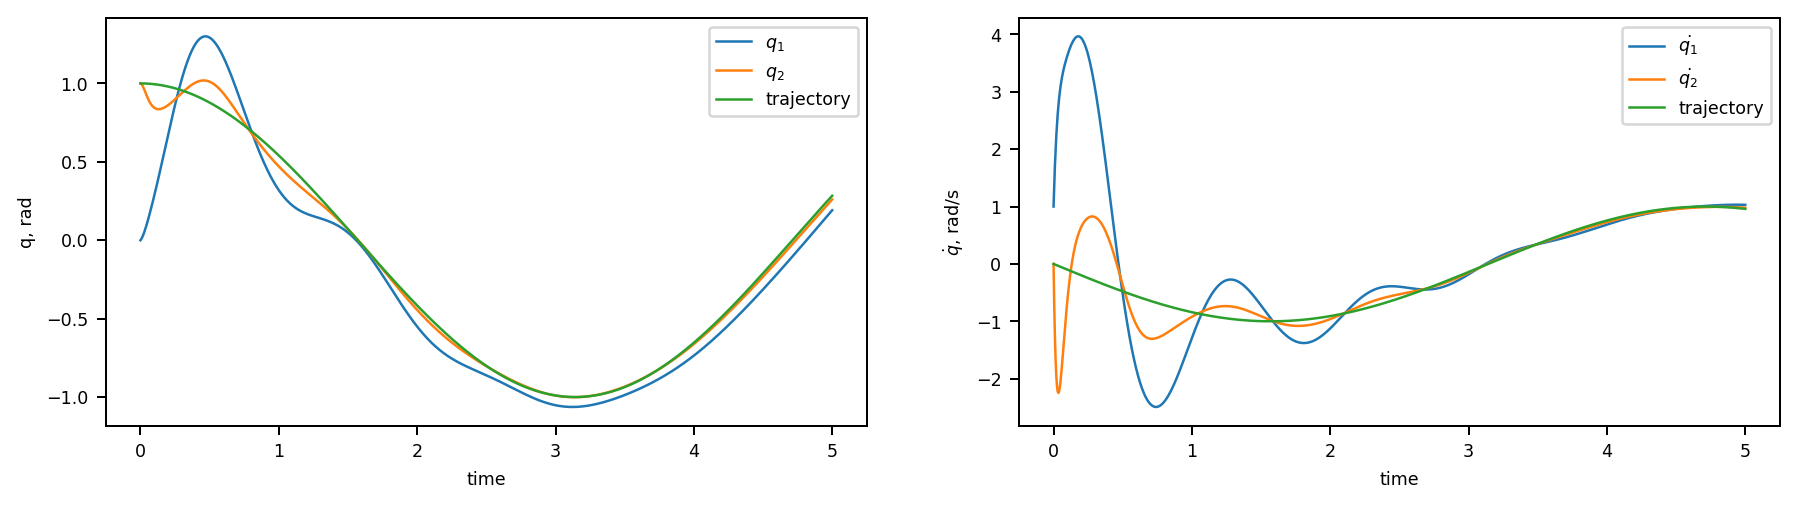

In [241]:
from math import cos, sin,tan

# PD Controller coefficients
K = [400, 30]


def trajectory(t):
  q_star = np.array([cos(t), cos(t)])
  q_star_prime = np.array([-sin(t), -sin(t)])
  
  return np.array([q_star, q_star_prime])

def discrete(x, time):
  plot = [x]
  for i in range(len(time)-1):
    # u = np.array([[1],[1]])
    q_desired = trajectory(time[i])
    u = (K[0]*(q_desired[0] - x[:2]) + K[1]*(q_desired[1]-x[2:])).reshape(2,1)
    
    result = odeint(system, x, [time[i], time[i+1]], args=(u,))
    plot.append(result[1])
    x = result[1]
  
  return np.array(plot)

t = np.linspace(0,5,1000)
q = np.array([0,1])
qdot = np.array([1,0])
x = np.array([q,qdot]).flatten()
solution = discrete(x, t)


figure = plt.figure(figsize=(12,3))
plt1 = figure.add_subplot(121)
plt2 = figure.add_subplot(122)


plt1.plot(t, solution[:,0], label='$q_1$')
plt1.plot(t, solution[:,1], label='$q_2$')
trajectory_graph = [trajectory(i)[0][0] for i in t]
plt1.plot(t, trajectory_graph, label='trajectory')
# plt.plot(t, solution[:,2], label='q3')
# plt.plot(t, solution[:,3], label='q4')
plt1.set_xlabel("time")
plt1.set_ylabel("q, rad")

plt2.plot(t, solution[:,2], label='$\dot{q_1}$')
plt2.plot(t, solution[:,3], label='$\dot{q_2}$')
trajectory2_graph = [trajectory(i)[1][0] for i in t]
plt2.plot(t, trajectory2_graph, label='trajectory')

plt2.set_xlabel("time")
plt2.set_ylabel("$\dot{q}$, rad/s")

plt1.legend()
plt2.legend()
plt.show()

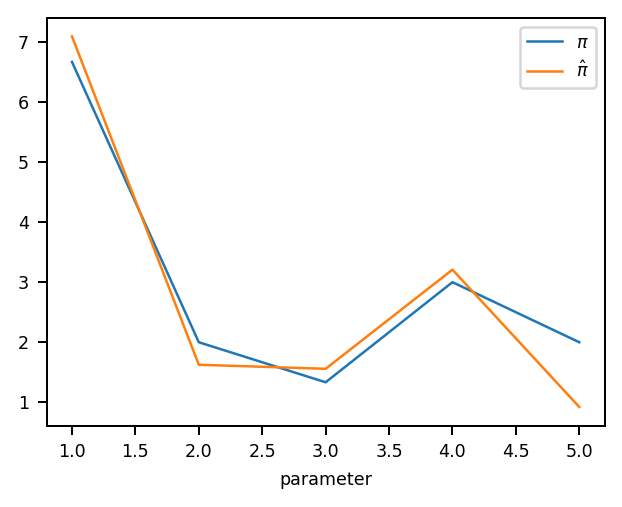

[7.09322208 1.62518067 1.55774916 3.20829338 0.92225054]


In [240]:
def Y(q, q_dot, q_ddot):
    q1, q2 = q.reshape(-1)
    q1_dot, q2_dot = q_dot.reshape(-1)
    q1_ddot, q2_ddot = q_ddot.reshape(-1)
    return np.array([
        [q1_ddot, cos(q2)*(2*q1_ddot+q2_ddot)-sin(q2)*(q1_dot**2+2*q1_dot*q2_dot), q2_ddot, g*cos(q1), g*cos(q1+q2)],
        [    0    ,              cos(q2)*q1_ddot+sin(q2)*q1_dot**2              ,q1_ddot+q2_ddot,    0,     g*cos(q1+q2)],])

def system(x,t,u):
  x = x.reshape(4,1)
  state = np.array([x[:2], x[2:]])

  M_inv = np.linalg.inv(M(state[0]))
  qdot_term = M_inv.dot( - ( C(state[0],state[1]).dot(state[1])) - G(state[0]).reshape(2,1)).flatten()
  f = np.array([state[1][0],state[1][1],
                qdot_term[0], qdot_term[1]]).reshape(4,1)
  
  M_inv_B = M_inv.dot(B).dot(u)
  gu = np.array([[0],[0], M_inv_B[0], M_inv_B[1]])
  return (f+gu).flatten()

def q_dot_PD(x, t):
  q_desired = trajectory(t)
  u = (K[0]*(q_desired[0] - x[:2]) + K[1]*(q_desired[1]-x[2:])).reshape(2,1)
  return system(x,t,u)



qs = solution[:,:2]
q_dots = solution[:,2:]
q_ddots = np.array([(q_dot_PD(np.array([*qs[i], *q_dots[i]]), t[i])[2:]) for i in range(len(t))])
Ys = np.array([Y(q, q_dot, q_ddot) for q, q_dot, q_ddot in zip(qs, q_dots, q_ddots)])
Ys = np.concatenate([i for i in Ys])

tau = np.array([(K[0]*(trajectory(t[i])[0] - qs[i]) + K[1]*(trajectory(t[i])[1]-q_dots[i])) for i in range(len(t))])

tau = np.concatenate([i for i in tau])
Ys_t = Ys.transpose()

value = [1,2,3,4,5]

pi_hat = (np.linalg.pinv(Ys) @ tau.reshape((-1, 1))).flatten()


pi = np.array([[m()[0]*lc()[0]**2+m()[1]*(l[0]**2+lc()[1]**2+I[0]+I[1])],
               [                m()[1]*l[0]*lc()[1]              ],
                [             m()[1]*lc()[1]**2 + I[1]            ],
                [             m()[0]*lc()[0] + m()[1]*l[0]            ],
                [                  m()[1]*l[1]                ]]).flatten()

plt.plot(value, pi, label='$\pi$')
plt.plot(value, pi_hat, label='$\hat{\pi}$')

plt.xlabel('parameter')
plt.legend()
plt.show()
# print(pi_hat)

[[0.01195714]
 [0.00893236]
 [0.00712467]
 [2.69448156]
 [1.725689  ]]


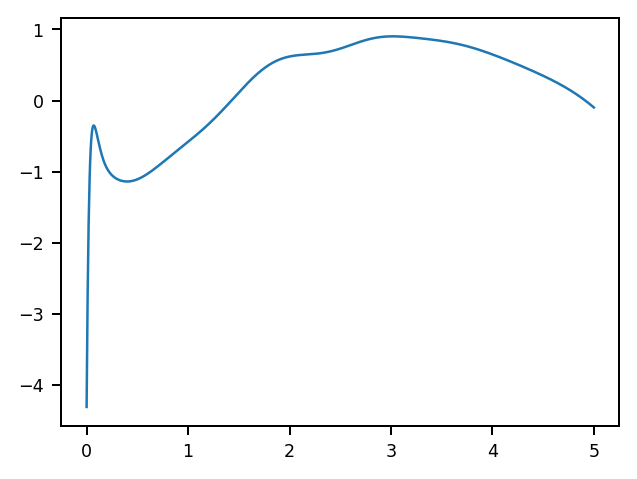

In [215]:
# coefficients
g = 9.8
l = np.array([2,2])

def m(t):
  m1 = 1+0.25*cos(0.25*t)
  m2 = 0.5 + sin(t)
  return np.array([m1, m2])

def lc():
  return np.array([1, 1])

def I(t):
  return np.array([(m(t)[0]*(lc()[0]*lc()[0]*lc()[0] + (l[0]-lc()[0])*(l[0]-lc()[0])*(l[0]-lc()[0])))/(3*l[0]),
              (m(t)[1]*(lc()[1]*lc()[1]*lc()[1] + (l[1]-lc()[1])*(l[1]-lc()[1])*(l[1]-lc()[1])))/(3*l[1])])

# matrices
def M(q,t):
  m00 = m(t)[0]*lc()[0]**2 + m(t)[1]*(l[0]**2 + lc()[1]**2 + 2*l[0]*lc()[1]*cos(q[1])) + I(t)[0] + I(t)[1]
  m01 = m10 = m(t)[1]*(lc()[1]*lc()[1] + l[0]*lc()[1]*cos(q[1])) + I(t)[1]
  m11 = m(t)[1]*lc()[1]*lc()[1] + I(t)[1]
  return np.array([[m00, m01],
                   [m10, m11]])
  
def C(q, qdot,t):
  # print(q)
  h = -m(t)[1]*l[0]*lc()[1]*sin(q[1])
  return np.array([[h*qdot[1], h*(qdot[0]+qdot[1])],
                   [-h*qdot[0], 0]])
  
def G(q,t):
  return np.array([(m(t)[0]*lc()[0] + m(t)[1]*l[0])*g*cos(q[0]) + m(t)[1]*lc()[1]*g*cos(q[0]+q[1]),
                   m(t)[1]*lc()[1]*g*cos(q[0]+q[1])])


def Y(q, q_dot, q_ddot):
    q1, q2 = q.reshape(-1)
    q1_dot, q2_dot = q_dot.reshape(-1)
    q1_ddot, q2_ddot = q_ddot.reshape(-1)
    return np.array([
        [q1_ddot, cos(q2)*(2*q1_ddot+q2_ddot)-sin(q2)*(q1_dot**2+2*q1_dot*q2_dot), q2_ddot, g*cos(q1), g*cos(q1+q2)],
        [    0    ,              cos(q2)*q1_ddot+sin(q2)*q1_dot**2              ,q1_ddot+q2_ddot,    0,     g*cos(q1+q2)],])

def system(x,t,u):
  x = x.reshape(4,1)
  state = np.array([x[:2], x[2:]])

  M_inv = np.linalg.inv(M(state[0],t))
  qdot_term = M_inv.dot( - ( C(state[0],state[1],t).dot(state[1])) - G(state[0],t).reshape(2,1)).flatten()
  f = np.array([state[1][0],state[1][1],
                qdot_term[0], qdot_term[1]]).reshape(4,1)
  
  M_inv_B = M_inv.dot(B).dot(u)
  gu = np.array([[0],[0], M_inv_B[0], M_inv_B[1]])
  return (f+gu).flatten()

def q_dot_PD(x, t):
  q_desired = trajectory(t)
  u = (K[0]*(q_desired[0] - x[:2]) + K[1]*(q_desired[1]-x[2:])).reshape(2,1)
  return system(x,t,u)

qs = solution[:,:2]
q_dots = solution[:,2:]
q_ddots = np.array([(q_dot_PD(np.array([*qs[i], *q_dots[i]]), t[i])[2:]) for i in range(len(t))])
# print(q_ddot)
Ys = np.array([Y(q, q_dot, q_ddot) for q, q_dot, q_ddot in zip(qs, q_dots, q_ddots)])
Ys = np.concatenate([i for i in Ys])

tau = np.array([(K[0]*(trajectory(t[i])[0] - qs[i]) + K[1]*(trajectory(t[i])[1]-q_dots[i])) for i in range(len(t))])

tau = np.concatenate([i for i in tau])
Ys_t = Ys.transpose()



pi_hat = np.linalg.pinv(Ys) @ tau.reshape((-1, 1))
print(pi_hat)


